In [1]:
%load_ext autoreload
%autoreload 2

import os

device_count = 10
os.environ["XLA_FLAGS"] = f"--xla_force_host_platform_device_count={device_count}"

import jax.numpy as np
import matplotlib.pyplot as plt

from kinn_function import initialize_training, train, load_data, batched_state, encode_reactions, rebuild_ode, batched_model, diff_state, uncertainty_analysis

In [2]:
data_train = load_data('../../data/TAP_thin_data.json',
          ['../../data/TAP_cat_in.json','../../data/TAP_cat_out.json'])

In [3]:
layer_sizes = [1, 8, 6]
model_size = [6]
params, opt_inv = initialize_training(layer_sizes, model_size)

In [4]:
err_tags = ['Data','Model']
num_epochs = 1000
num_iter = 10
rxn = ['CO + * <-> CO*',
       'O2 + 2* -> 2O*',
       'CO* + O* <-> CO2 + 2*',
       'CO + O* -> CO2 + *']
species = ['CO','O2','CO2','CO*','O*','*']
encoded_rxn = encode_reactions(rxn,species)
weighted_param = 1e-10

# The loop below is set up to mimic the manual changing of the weighted_param value, but please note
# it cannot fully replicate the manual fine-tuning process. It is just a sample demonstration of how
# the weighted_param value can be changed during training.
# If you have any question about the detail tunning of weighted parameter, please contact dnai3@gatech.edu

for j in range(9):
       cycle = 5 - j//2
       for i in range(cycle):
              params = train(params,data_train,num_epochs,num_iter,opt_inv,err_tags,
                             encoded_rxn,device_count,weighted_param)    
              [params, opt_inv] = params
              nn_params_inv, model_params_inv = params
              nn_params = nn_params_inv
              model_params = model_params_inv
       weighted_param *= 4

standard_deviation = uncertainty_analysis(params, data_train, weighted_param, encoded_rxn)

6.5536e-06
Epoch:  999, Loss Batch: 7.25450e-04, Fit Data: 1.77587e-02, Fit Model: 9.83133e-02
[Array([-11.62356597,   0.52970994,  -0.25473885,   0.33661978,
         0.0235438 ,  11.46062955], dtype=float64)]


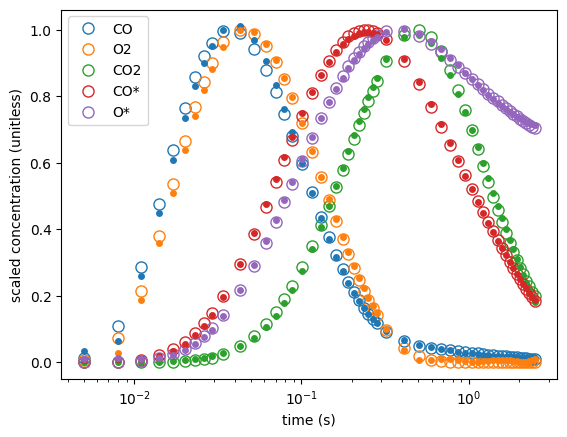

In [39]:
fig, axs = plt.subplots()
axs.plot(np.exp(data_train[0][1][::3,0]), data_train[0][0][::3,0:5], 'o', markerfacecolor='None', ms = 8)
axs.legend(['CO', 'O2', 'CO2', 'CO*', 'O*'])
axs.set_prop_cycle(None)
axs.plot(np.exp(data_train[0][1][::3]),batched_state(nn_params_inv, data_train[0][1])[::3,0:5],'o',
                      ms=5,markeredgecolor='none')
axs.set_xscale('log')
axs.set_xlabel('time (s)')
axs.set_ylabel('scaled concentration (unitless)');

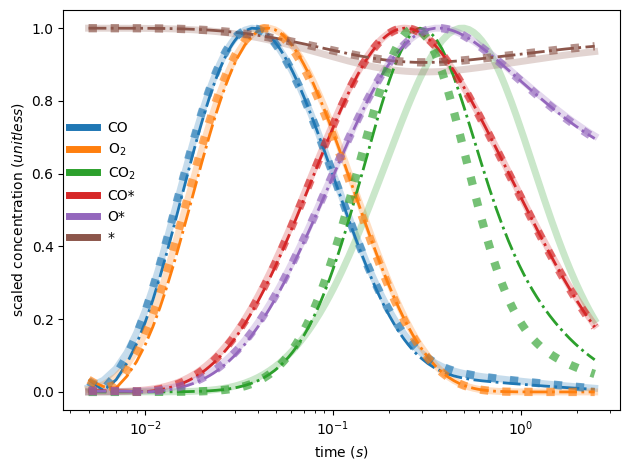

In [8]:
solution, solution_true = rebuild_ode(model_params, data_train, encoded_rxn)

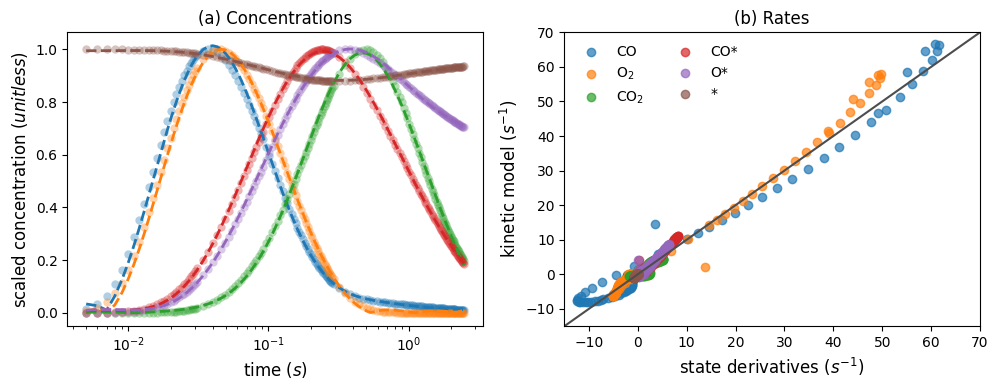

In [98]:
# The code below shows how we generate the figure in the paper. Note the figure might not look exactly
# the same as in the manuscript without manually hyperparameter tunning because of the convergence 
# and model selection issue.
# If you have any question about the figure generation, please contact dnai3@gatech.edu

(_, t_train, net_flux_train), y_train_scale, _ = data_train

pred_x = batched_state(nn_params,t_train)
x_rescale = pred_x
kinetic_model = batched_model([x_rescale,t_train],model_params,net_flux_train,
                              y_train_scale,encoded_rxn) / y_train_scale

model_pred = kinetic_model 
model_diff = diff_state(nn_params,t_train) / np.exp(t_train)

fig, axs = plt.subplots(1, 2, figsize = (10, 4), tight_layout = True)

axs[0].plot(np.exp(data_train[0][1][::,0]), data_train[0][0][::,0:], 'o', markeredgecolor='none', 
            ms = 6, alpha = 0.35)
axs[0].set_prop_cycle(None)
axs[0].plot(np.exp(data_train[0][1][:]), batched_state(nn_params_inv, data_train[0][1])[:,0:],'--',
                      linewidth = 2,markeredgecolor='none')
axs[0].set_title('(a) Concentrations')
axs[0].set_xlabel('time ($s$)', fontsize = 12)
axs[0].set_ylabel('scaled concentration ($unitless$)', fontsize = 12)
axs[0].set_xscale('log')

for i in range(6):
    axs[1].scatter(model_pred[:,i], model_diff[:,i],
               color = 'C{}'.format(i), alpha = 0.7)
axs[1].set(xlim=(-15, 70), ylim=(-15, 70))
axs[1].plot(axs[1].get_xlim(), axs[1].get_ylim(), ls="-", c = '.3')
axs[1].set_xlabel('state derivatives ($s^{-1}$)', fontsize = 12)
axs[1].set_ylabel('kinetic model ($s^{-1}$)', fontsize = 12)
axs[1].set_title('(b) Rates')

axs[1].legend(['CO', 'O$_2$', 'CO$_2$', 'CO*', 'O*', '*'], ncol = 2, frameon = False);

Text(0.5, 0, '$k_{TRUE}$')

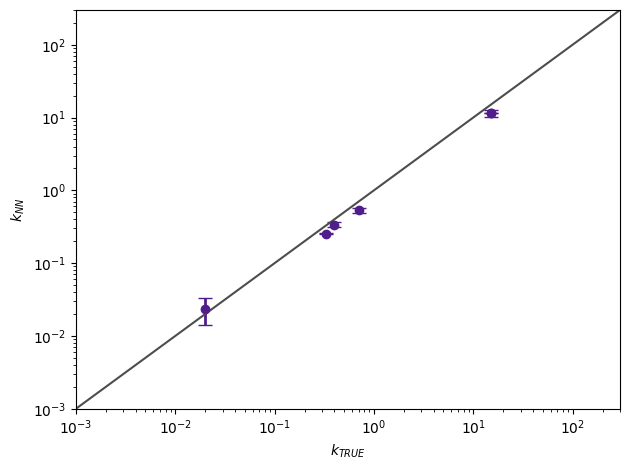

In [6]:
model_params_true = np.array([15, 0.7, 0.33, 0.4, 0.02, 15.2])
model_params_fit = np.abs(model_params_inv[0])

model_params_err = standard_deviation

fig, axs = plt.subplots(tight_layout = True)

axs.errorbar(model_params_true, model_params_fit, yerr = model_params_err, fmt = 'o',
               color = '#501d8a', elinewidth = 2, capsize = 5)
axs.set_yscale('log')
axs.set_xscale('log')
axs.set(xlim=(0.001, 300), ylim=(0.001, 300))
axs.plot(axs.get_xlim(), axs.get_ylim(), ls="-", c = '.3')
axs.set_ylabel('$k_{NN}$')
axs.set_xlabel('$k_{TRUE}$')

In [7]:
standard_deviation

Array([0.09067964, 0.04650412, 0.00267175, 0.0272962 , 0.00955282,
       1.26325204], dtype=float64)